# P4: RL & MCTS

[Instructions are the same as they have been. You know the drill by now.]

To begin, you will revisit the graph problem from the last assignment, yet this time you will solve it using Q-Learning!

In [41]:
# Starter Code: Graph definition and plotting (the same as P3)

import matplotlib.pyplot as plt
import numpy as np
import random


def get_random_adjacency(band_size, num_nodes, edge_rate=1.0, seed=695):
    random.seed(seed)
    mat = np.zeros((num_nodes, num_nodes))
    for ii in range(num_nodes):
        mat[ii, ii] = 1.0
        for jj in range(ii + 1, min(ii+band_size, num_nodes)):
            val = 1.0 * (random.random() < edge_rate)
            mat[ii, jj] = val
            mat[jj, ii] = val
    return mat


def plot_adjacency_mat(mat):
    plt.figure(dpi=150)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(mat, interpolation='none')


class AdjacencyWorld(object):
    def __init__(self, num_nodes, band_size=10, edge_rate=0.5, random_move_chance=0.5, seed=695):
        self.mat = get_random_adjacency(band_size=band_size, num_nodes=num_nodes, edge_rate=edge_rate, seed=seed)
        self.states = list(range(num_nodes))
        self.rewards = -1 * np.ones((num_nodes))
        self.goal = num_nodes//2
        self.rewards[self.goal] = 10
        self.random_move_chance = random_move_chance
    
    def get_actions_for_state(self, state): 
        """Get the available 'moves' from the current state.
        return: list of indices connected to 'state'."""
        return np.where(self.mat[state])[0].tolist()
    
    def get_transition_probs(self, state, action):
        """Get a list of the transition probabilities for a state and action."""
        actions = self.get_actions_for_state(state)
        num_actions = len(actions)
        prob_vec = np.zeros_like(self.rewards)
        for rand_action in actions:
            prob_vec[rand_action] = self.random_move_chance / num_actions
        
        prob_vec[action] += (1 - self.random_move_chance)
        return prob_vec
    
    def get_random_state(self):
        return random.choice(self.states)

    def execute_action(self, state, action):
        assert action in self.get_actions_for_state(state)
        probs = self.get_transition_probs(state, action)
        new_state = np.random.choice(self.states, p=probs)
        return self.rewards[new_state], new_state

## P4.1: Q Learning

Next, you'll be implementing Q Learning. Instructions here are a bit sparse, but I figure you probably know what you're doing by now!

**TASK** Implement Q Learning (use the lecture slides as a reference).

**TASK** Complete the `evaluate_policy` function using your implementation from the previous assignment (or mine). We will not grade this function, but it is necessary to complete your Q Learning evaluation code.

**CODE** Include your Q Learning implementation in your writeup

**PLOTS** Run the evaluation code below. Include all plots and the results (the average value for each value of the learning rate) in your writeup. You should notice the performance peaks around a learning rate of 0.02.

**QUESTION** (1-3 sentences) The rate of convergence for Q learning is significantly slower than that of Value Iteration. What information does Value Iteration have access to (and indeed makes use of) that makes it converge faster?

**QUESTION** (3-5 sentences) When the learning rate is very low, the performance is not particularly good. From looking at the plots of the total reward over time, what is likely the cause? How would you fix this issue (without changing the learning rate)?

**QUESTION** (2-4 sentences) When the learning is too high, the performance is also not very good. Why does this happen?


In [42]:
# Starter Code: Q Learning

def Q_learning(env, num_iterations, num_steps=30, gamma=0.98,
               learning_rate=0.005, epsilon=0.1, seed=695):
    random.seed(seed)
    np.random.seed(seed)
    Q_s_a = np.zeros((len(env.states), len(env.states)))
    total_rewards = []
    # Iterate
    for ii in range(num_iterations):
        # Rollout
        total_reward = 0
        state = env.get_random_state()
        for ii in range(num_steps):
            # Take an action and get the reward
            # raise NotImplementedError()
            actions = env.get_actions_for_state(state)
            v_a = []
            for act in actions:
                q_a = Q_s_a[state, act]
                v_a.append(q_a)
            if np.random.rand() > epsilon:
                indx = np.argmax(v_a)
                action = actions[indx]
            else:
                indx = np.random.randint(0,len(actions))
                action = actions[indx]
            r, new_state = env.execute_action(state, action)
            # Update Q
            maxQ = np.max(Q_s_a[new_state])
            Q_s_a[state, action] += learning_rate*(r+gamma*maxQ - 
                                            Q_s_a[state, action])
            # raise NotImplementedError()
            
            # Update reward and state
            total_reward += r
            state = new_state

        total_rewards.append(total_reward)

    policy = np.zeros(len(env.states))
    for state in env.states:
        actions = env.get_actions_for_state(state)
        action_ind = np.argmax(Q_s_a[state, actions])
        policy[state] = actions[action_ind]
    return list(policy.astype(int)), total_rewards

In [43]:
def evaluate_policy(env, policy, gamma=0.98):
    """Returns a list of values[state]."""
    P = np.zeros((len(env.states),len(env.states)))
    R = np.zeros(len(env.states))
    I = np.eye(len(env.states))
    for ii, state in enumerate(env.states):
        R[ii] = env.rewards[ii]
        action = policy[state]
        prob_vec = env.get_transition_probs(state, action)
        P[ii] += prob_vec
    V = np.linalg.solve(I-gamma*P, R)
    return V

Q Learning Avg. Value (0.001): 213.38232824022384
Q Learning Avg. Value (0.005): 257.6895207980598
Q Learning Avg. Value (0.02): 233.18561167028193
Q Learning Avg. Value (0.1): 207.74978680233946
Q Learning Avg. Value (1.0): -49.52500830385597


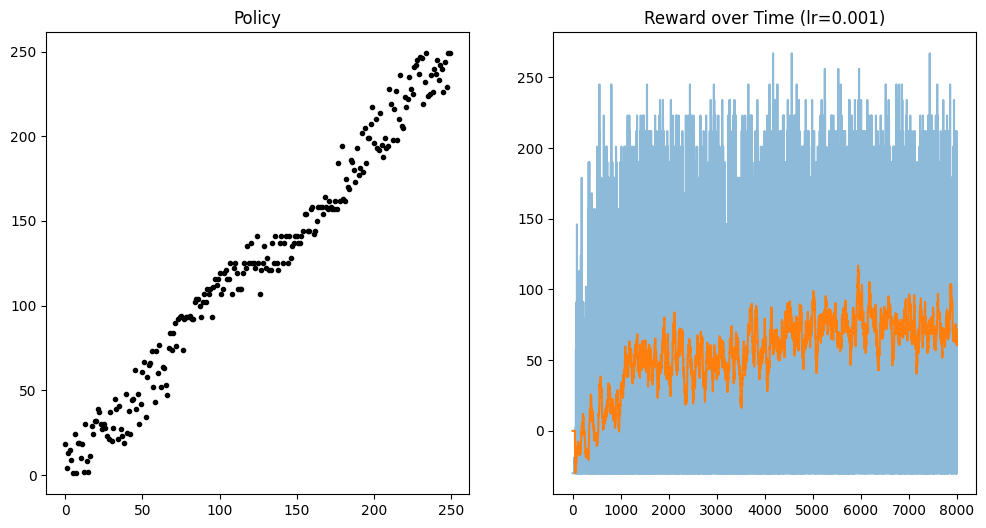

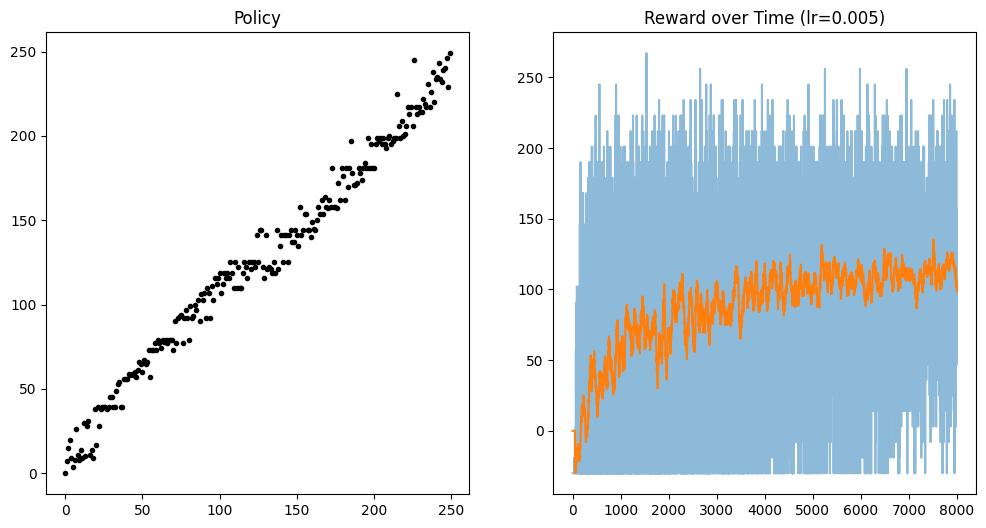

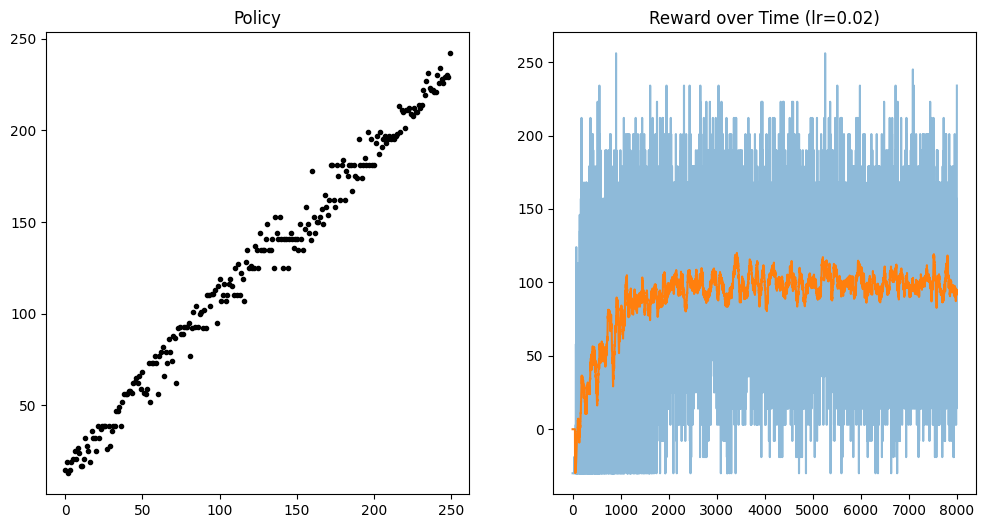

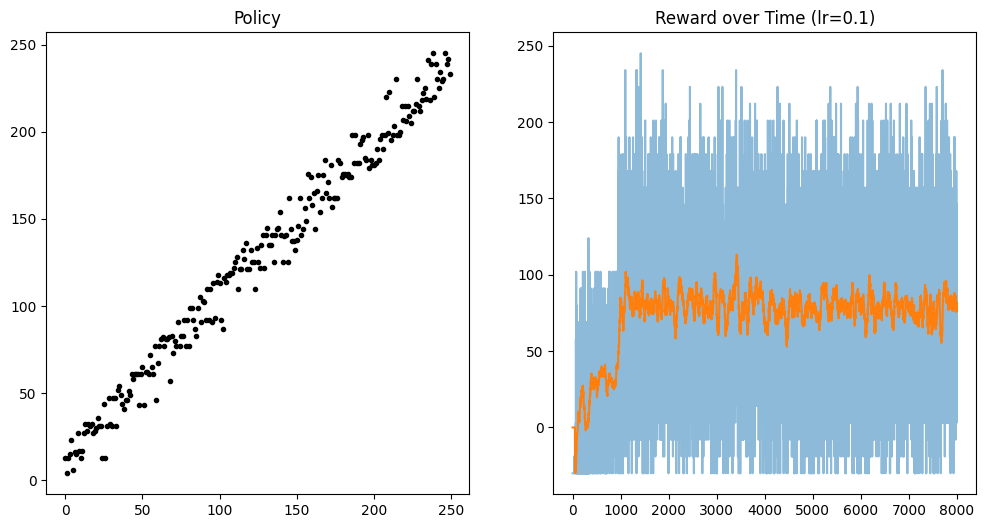

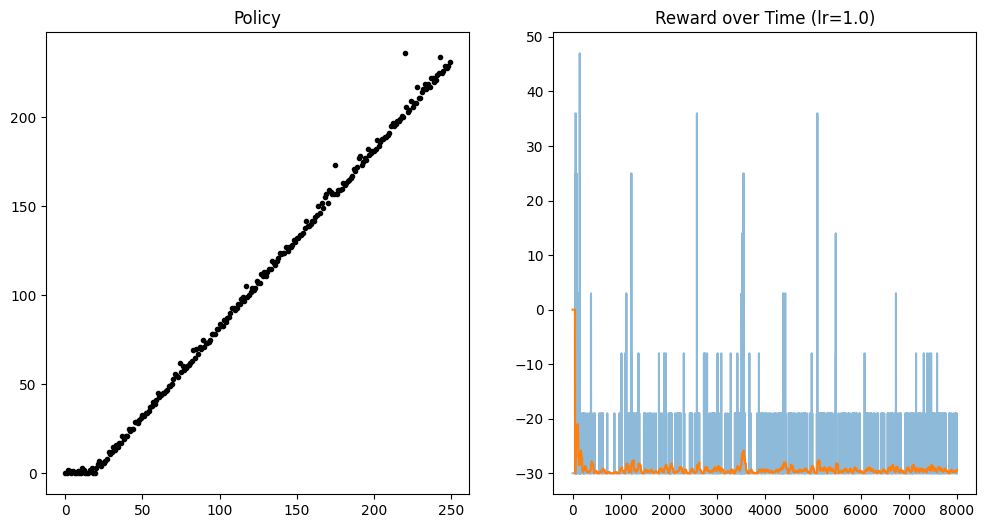

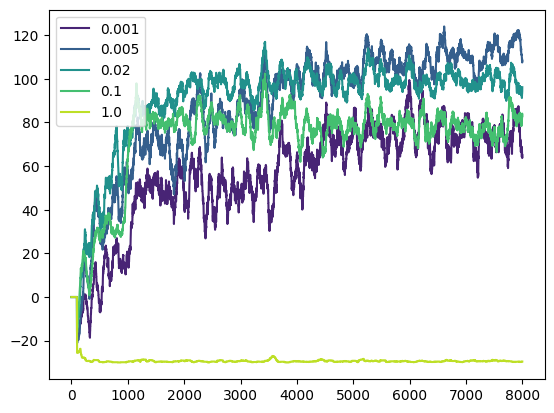

In [44]:
# Evaluation code

world = AdjacencyWorld(250, band_size=20, edge_rate=0.4, random_move_chance=0.3)

def smooth_data(data, window_width=50):
    summed_data = np.cumsum(data)
    sm_data = (summed_data[window_width:] - summed_data[:-window_width]) / window_width
    return np.concatenate([np.zeros(window_width), sm_data])


def evaluate_q_learning(learning_rate):
    policy_ql, rewards = Q_learning(world, num_iterations=8000,
                                    learning_rate=learning_rate)
    pv = evaluate_policy(world, policy_ql)
    print(f"Q Learning Avg. Value ({learning_rate}): {np.mean(pv)}")

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(policy_ql, 'k.')
    plt.title('Policy')

    plt.subplot(122)
    plt.plot(rewards, alpha=0.5)
    plt.plot(smooth_data(rewards))
    plt.title(f'Reward over Time (lr={learning_rate})')

    return rewards

# policy_pi, _ = policy_iteration(world, num_iterations=100, gamma=0.98)
# pv = evaluate_policy(world, policy_pi)
# print(f"Policy Iteration Avg. Value: {np.mean(pv)}")

rewards_0p001 = evaluate_q_learning(learning_rate=0.001)
rewards_0p005 = evaluate_q_learning(learning_rate=0.005)
rewards_0p02 = evaluate_q_learning(learning_rate=0.02)
rewards_0p1 = evaluate_q_learning(learning_rate=0.10)
rewards_1 = evaluate_q_learning(learning_rate=1.00)

from matplotlib import colormaps
plt.figure()
cmap = colormaps['viridis']
plt.plot(smooth_data(rewards_0p001, 100), color=cmap(0.1))
plt.plot(smooth_data(rewards_0p005, 100), color=cmap(0.3))
plt.plot(smooth_data(rewards_0p02, 100), color=cmap(0.5))
plt.plot(smooth_data(rewards_0p1, 100), color=cmap(0.7))
plt.plot(smooth_data(rewards_1, 100), color=cmap(0.9))
plt.legend(["0.001", "0.005", "0.02", "0.1", "1.0"])
None

## P4.2 Deep Q Learning (following a tutorial)

In the last programming assignment, you were asked to implement Q learning. Since then, we've discussed *Deep Reinforcement Learning*, in which deep learning is used to learn to approximate the Q function. While deep learning is somewhat out of scope for this class, I thought it would be instructive for you to follow a tutorial for Deep RL and tune the parameters a bit. The following link takes you to a Google Collab notebook, which lets you connect to a (free, with a Google account) cloud GPU on which the experiments will be run:

- Link to the tutorial page: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- In that page is a link to the Google Collab page: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/9da0471a9eeb2351a488cd4b44fc6bbf/reinforcement_q_learning.ipynb#scrollTo=sSQst1iEFdGV

**TASK** Before we begin, navigate to the "Training Loop" section and modify the `num_episodes` variable (set to 50 when the GPU is not used in the second code block in that section) so `num_episodes = 600` even when you're using the CPU. This is important becase, as the text above this block states: "50 episodes is insufficient for to observe good performance on CartPole."

**TASK/PLOT** After making the modification, click on `Runtime` in the top menu bar and `Restart and run all`. This will run all the code and train a Deep Q Network to solve the Cartpole V1 environment. Note: if this box is grayed out, you may need to click "Connect" on the top right to connect to the CPU/GPU. Include the resulting performance plot in your writeup, which should show return + average return vs episode.

**QUESTION** How does the algorithm perform? How does the final average return compare to the maximum possible value?

**TASK/PLOTS** Now you'll modify som parameters! The system is pretty dialed in as is, but it's somewhat slow to converge. Navigate to the Hyperparameters section under Training and modify a few things: you should **run three different configurations of hyperparameters**. Include: (i) the hyperparameters you changed, (ii) why you thought to change those (e.g., what was your process for deciding), and (iii) the results plot. Note that you are not required to improve performance, so you will not be evaluated on final performance.

**QUESTION** (3--6 sentences) Describe how parameter tuning went? Include any surprises you encountered along the way.


## P4.3 Connect Four and MCTS

I have provided you with a (pure python) implementation of the popular turn-based game "Connect Four". In this game, you 'drop' pieces of different color into the game board, trying to get four in a row (along any axis) before your opponent can. In this question, I have provided you with an implementation of minimax search, which you will use to compare against your own implementation of Monte Carlo Tree Search.

### P4.3.1 Minimax

I have provided you with an already-complete minimax algorithm implementation. The algorithm has an element of randomness in it: if it multiple actions are of equal value, it picks one at random. The evaluation code below pits two different minimax algorithms against one another: one that runs at depth 5 and one that runs at depth 3.

**QUESTION** (2-3 sentences) What is the evaluation function being used to evaluate the goodness of a board state once the maximum depth is reached? How "useful" is the value function I have provided?

**TASK** Run the evaluation code below and observe the results.

**RESULTS** Include the win/draw counts in your writeup.

**QUESTION** (1-3 sentences) You may notice that sometimes the depth-3 minimax search wins against the depth-5 minimax search. How is this possible?


In [2]:
# Connect Four Implementation
import copy
import numpy as np
import random


class ConnectFourBoard(object):
    def __init__(self, nrows=6, ncols=7):
        self.current_player = 1
        self.nrows = nrows
        self.ncols = ncols
        self.board = np.zeros((nrows, ncols), int)
        self.winner = None

    def get_moves(self):
        return np.where(self.board[0] == 0)[0]

    def _check_winner(self, row, col):
        """Check if the move in col ended the game.
        Not wonderful code, but easy to follow and debug."""
        b, r, c = self.board, row, col
        
        # Diagonal 1
        if r - 3 >= 0 and c - 3 >= 0:
            if b[r, c] == b[r-1, c-1] == b[r-2, c-2] == b[r-3, c-3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c - 2 >= 0 and r + 1 < self.nrows and c + 1 < self.ncols:
            if b[r+1, c+1] == b[r, c] == b[r-1, c-1] == b[r-2, c-2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c - 1 >= 0 and r + 2 < self.nrows and c + 2 < self.ncols:
            if b[r+2, c+2] == b[r+1, c+1] == b[r, c] == b[r-1, c-1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c + 3 < self.ncols:
            if b[r+3, c+3] == b[r+2, c+2] == b[r+1, c+1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Diagonal 2
        if r - 3 >= 0 and c + 3 < self.ncols:
            if b[r, c] == b[r-1, c+1] == b[r-2, c+2] == b[r-3, c+3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c + 2 < self.ncols and r + 1 < self.nrows and c - 1 >= 0:
            if b[r+1, c-1] == b[r, c] == b[r-1, c+1] == b[r-2, c+2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c + 1 < self.ncols and r + 2 < self.nrows and c - 2 >= 0:
            if b[r+2, c-2] == b[r+1, c-1] == b[r, c] == b[r-1, c+1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c - 3 >= 0:
            if b[r+3, c-3] == b[r+2, c-2] == b[r+1, c-1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Flat
        if c + 3 < self.ncols:
            if b[r, c] == b[r, c+1] == b[r, c+2] == b[r, c+3]:
                self.winner = b[r, c]
                return
        if c + 2 < self.ncols and c - 1 >= 0:
            if b[r, c-1] == b[r, c] == b[r, c+1] == b[r, c+2]:
                self.winner = b[r, c]
                return
        if c + 1 < self.ncols and c - 2 >= 0:
            if b[r, c-2] == b[r, c-1] == b[r, c] == b[r, c+1]:
                self.winner = b[r, c]
                return
        if c - 3 >= 0:
            if b[r, c-3] == b[r, c-2] == b[r, c-1] == b[r, c]:
                self.winner = b[r, c]
                return
                
        # Down
        if r - 3 >= 0:
            if b[r, c] == b[r-1, c] == b[r-2, c] == b[r-3, c]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows:
            if b[r+3, c] == b[r+2, c] == b[r+1, c] == b[r, c]:
                self.winner = b[r, c]
                return

    def copy(self):
        return copy.deepcopy(self)

    def play_move(self, col):
        try:
            row = np.where(self.board[:, col] == 0)[0][-1]
        except IndexError:
            raise ValueError(f"Cannot play column '{col}'.")
        self.board[row, col] = self.current_player

        # Check for a winner
        self._check_winner(row, col)
        
        # Check if no more moves
        if len(self.get_moves()) == 0:
            self.winner = 0
        
        # Switch player
        if self.current_player == 1:
            self.current_player = 2
        else:
            self.current_player = 1
        
        return self
            
    def play_random_move(self):
        self.play_move(random.choice(self.get_moves()))
    
    def play_random_moves_until_done(self):
        while self.winner is None:
            self.play_random_move()

        return self.winner
            
    def __str__(self):
        string = ''
        print()
        for row in self.board:
            string += f"|{row}|\n"
        string += '=' * (2 * self.ncols + 3)
        
        return string
    
# Some simple tests
print("A board and randomly playing moves.")
board = ConnectFourBoard(nrows=6, ncols=7)
print(board)
print(board.get_moves())

while board.winner is None:
    board.play_random_move()

print(board)
print(board.winner)


A board and randomly playing moves.

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
[0 1 2 3 4 5 6]

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[1 0 0 2 1 0 0]|
|[2 0 0 1 2 0 1]|
|[2 0 1 2 1 0 2]|
|[2 1 1 2 1 2 1]|
1


In [3]:
# Minimax search
def minimax(state, depth, is_max_turn=True, is_start=True, player=None, verbose=False):
    if player is None:
        player = state.current_player
    if depth == 0 or state.winner is not None:
        if state.winner is None or state.winner == 0:
            return 0
        else:
            return 2 * (state.winner == player) - 1

    moves = state.get_moves()
    values = [minimax(state.copy().play_move(move), depth - 1, not is_max_turn, 
                      is_start=False, player=player)
              for move in moves]

    if is_start: # only at the start call, return the action. Otherwise return the value
        best_actions = np.where(np.array(values) == max(values))[0]
        action_ind = random.choice(best_actions)
        if verbose:
            print(list(zip(values, moves)), action_ind)
        return moves[action_ind]
    if is_max_turn:
        return max(values)
    else:
        return min(values)

In [3]:
# minimax evaluation code

def print_wins_minimax(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"Depth 6 Wins: {len([w for w in wins if w == 1])}")
    print(f"Depth 4 Wins: {len([w for w in wins if w == 2])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)
    
    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)


|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[2 0 2 0 0 0 0]|
|[2 2 1 1 1 1 0]|
1
Total Plays: 1
Depth 6 Wins: 1
Depth 4 Wins: 0
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 2 0 0]|
|[2 2 1 1 1 1 2]|
1
Total Plays: 2
Depth 6 Wins: 2
Depth 4 Wins: 0
Draws: 0

|[0 0 0 0 0 0 2]|
|[0 0 0 0 0 0 2]|
|[0 0 0 0 0 0 1]|
|[0 0 0 0 0 0 1]|
|[0 0 2 1 1 1 1]|
|[2 2 2 1 2 1 2]|
1
Total Plays: 3
Depth 6 Wins: 3
Depth 4 Wins: 0
Draws: 0

|[0 0 2 0 0 0 0]|
|[2 0 1 0 0 0 2]|
|[1 1 1 2 0 2 2]|
|[1 1 1 2 2 1 1]|
|[1 2 2 1 2 2 1]|
|[2 1 2 2 1 1 1]|
1
Total Plays: 4
Depth 6 Wins: 4
Depth 4 Wins: 0
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 2 0 0 0 0]|
|[0 0 2 0 0 0 0]|
|[2 1 1 1 1 2 1]|
1
Total Plays: 5
Depth 6 Wins: 5
Depth 4 Wins: 0
Draws: 0

|[0 2 1 2 2 0 2]|
|[1 1 1 1 2 0 1]|
|[2 2 2 1 1 0 1]|
|[1 1 2 2 2 0 2]|
|[1 1 1 2 1 0 2]|
|[2 2 1 2 1 1 2]|
1
Total Plays: 6
Depth 6 Wins: 6
Depth 4 Wins: 0
Draws: 

### P4.3.2 Monte-Carlo Tree Search

*Note: regardless of which algorithm goes first, MCTS is always represented by the number '2' in the printed out board states and minimax is always '1'*

**TASK** Complete the functions `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct`.

**CODE** Include your implementations of `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct` in your writeup.

**TASK** Run the evaluation code below. (Note that it may take a few minutes to run all 25 games.)

**QUESTION+RESULTS+PLOTS** For the given configuration (1000 iterations, C=5), which algorithm wins more often? Pick a couple final board states (printed out when one strategy wins) and include them in your writeup (screenshots are acceptable).

**QUESTION+RESULTS** Rerun the experiments with C=0.1 and C=25. Include the win rates; how well does MCTS perform when you change C?

**QUESTION+PLOTS** (4-5 sentences) Describe how the behavior of the MCTS changes when you change the value of C. Pick a couple final board states (printed out when one strategy wins) that support your conclusion and include them in your writeup (screenshots are acceptable). In your answer, you might consider discussing the types of ways MCTS wins/loses for different values of C. Be sure to label which value of C was used for each final board state you include in your writeup.

In [49]:
# Starter Code: MCTS Implementation
import time


class Tree():
    def __init__(self, *, start_state=None, parent=None, move=None):
        if parent is None:
            self.parent = None
            self.move = None
            self.state = start_state
        else:
            self.parent = parent
            self.move = move
            self.state = parent.state.copy()
            self.state.play_move(move)
        
        self.values = []
        self.n = 0
        if self.is_terminal_state:
            self.unexplored_moves = set()
        else:
            self.unexplored_moves = set(self.state.get_moves())
        self.children = set([])
            
    @property
    def fully_expanded(self):
        return len(self.unexplored_moves) == 0
    
    @property
    def is_terminal_state(self):
        return (self.state.winner is not None)


def monte_carlo_tree_search(start_state, num_iterations=1000):
    """MCTS core loop"""
    # Start by creating the root of the tree.
    root = Tree(start_state=start_state)
    for _ in range(num_iterations):
        leaf = traverse(root)
        sim_result = rollout(leaf, start_state)
        backpropagate(leaf, sim_result)
    return best_child(root)

def best_child(node):
    """When done sampling, pick the child visited the most."""
    children = node.children
    m_max = 0
    for child in children:
        if child.n >= m_max:
            child_select = child
            m_max = child.n
    select_move = 0
    moves = node.state.get_moves()
    for move in moves:
        if (node.state.copy().play_move(move).board == 
                        child_select.state.board).all():
            select_move = move
    return select_move

def best_uct(node, C=0.1):
    """Pick the best action according to the UCB/UCT algorithm"""
    bandit_Q = []
    for jj, child in enumerate(node.children):
        Q_mean = np.average(child.values)
        ucb = C*np.sqrt(np.log(node.n)/child.n)
        val = Q_mean + ucb
        bandit_Q.append(val)
    bandit_ind = np.argmax(bandit_Q)
    return list(node.children)[bandit_ind]
    
    
    

def traverse(node):
    # If fully explored, pick one of the children
    while node.fully_expanded and not node.is_terminal_state:
        node = best_uct(node)
    # If the node is terminal, return it
    if node.is_terminal_state:
        return node
    
    # If the node is not terminal:
    # 1. pick a new move from 'unexplored_moves'
    move = node.unexplored_moves.pop()
    # 2. create a new child
    new_child = Tree(parent=node, move=move)
    # 3. add that child to the list of children
    node.children.add(new_child)
    # 4. return that new child
    return new_child


def rollout(node, start_state):
    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1


def backpropagate(node, simulation_result):
    """Update the node and its parent (via recursion)."""
    if node is None:
        return
    node.values.append(simulation_result)
    node.n += 1
    backpropagate(node.parent, simulation_result)
    

In [50]:
# Evaluation Code

def print_wins(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"MiniMax Wins: {len([w for w in wins if w == 1])}")
    print(f"MCTS Wins: {len([w for w in wins if w == 2])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")

wins = []
for _ in range(25):
    tot_time_minimax = 0
    tot_time_mcts = 0
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    count =0
    while board.winner is None:
        ++count
        if board.current_player == 1:
            stime = time.time()
            action = minimax(board, depth=5, verbose=False)
            # print("minimax")
            # print(action)
            tot_time_minimax += time.time() - stime
        else:
            stime = time.time()
            action = monte_carlo_tree_search(board)
            # print("MCTS")
            # print(action)
            tot_time_mcts += time.time() - stime
        board.play_move(action)
        # if count>=2:
        #     break
    
    print(board)
    print(f"Winner: {board.winner}")
    print(tot_time_minimax, tot_time_mcts)
    wins.append(board.winner)
    print_wins(wins)


|[0 1 0 2 2 2 0]|
|[0 1 0 1 1 1 0]|
|[1 1 0 1 1 2 0]|
|[2 2 0 2 2 2 2]|
|[2 2 0 1 2 1 1]|
|[1 2 1 1 2 1 2]|
Winner: 2
5.075525283813477 7.646624326705933
Total Plays: 1
MiniMax Wins: 0
MCTS Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 2 1 0 2 0 1]|
|[0 1 1 0 1 0 2]|
|[0 2 1 0 2 0 2]|
|[0 1 1 2 1 0 2]|
Winner: 1
4.479376316070557 5.927496671676636
Total Plays: 2
MiniMax Wins: 1
MCTS Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 1 0 1 0 0 0]|
|[0 2 2 1 0 0 0]|
|[0 2 1 1 2 0 0]|
|[0 2 2 1 1 1 2]|
Winner: 1
3.5892040729522705 5.164338827133179
Total Plays: 3
MiniMax Wins: 2
MCTS Wins: 1
Draws: 0

|[0 1 0 1 0 2 0]|
|[2 1 0 1 2 2 0]|
|[1 2 0 1 1 1 0]|
|[2 1 0 1 2 2 0]|
|[2 1 0 2 2 2 1]|
|[1 2 0 2 1 2 1]|
Winner: 1
5.487369060516357 7.947678089141846
Total Plays: 4
MiniMax Wins: 3
MCTS Wins: 1
Draws: 0

|[1 0 0 0 0 0 0]|
|[1 2 0 0 0 2 0]|
|[1 2 0 1 0 1 0]|
|[1 1 0 2 0 2 0]|
|[2 2 2 1 0 2 0]|
|[1 1 2 1 2 2 1]|
Winner: 1
5.287829875946045 6.635411739349365
Total Plays: